In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model   #数据模型
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa import stattools #模型工具

%matplotlib inline
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

from arch.unitroot import ADF
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import re

In [55]:
class PairTrading:
    def SSD(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('缺少价格序列')
        else:
            returnx = (priceX-priceX.shift(1))/priceX.shift(1)[1:]
            returny = (priceX-priceY.shift(1))/priceY.shift(1)[1:]
            stdx = (returnx+1).cumprod()
            stdy = (returny+1).cumprod()
            SSD = np.sum((stdx-stdy)**2)
            return(SSD)
        
    def SSDSpread(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('缺少价格序列')
        priceX = np.log(priceX)
        priceY = np.log(priceY)
        retx = priceX.diff()[1:]
        rety = priceY.diff()[1:]
        standardX = (1+retx).cumprod()
        standardY = (1+rety).cumprod()
        spread = standardY-standardX
        return (spread)
        
    def cointegration(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('缺少价格序列')
        priceX = np.log(priceX)
        priceY = np.log(priceY)
        results = sm.OLS(priceY,sm.add_constant(priceX)).fit()
        resid =results.resid
        adfSpread = ADF(resid)
        if adfSpread.pvalue>=0.05:
            print('''交易价格不具有协整关系.
            p-value of ADF test: %f
            Coefficients of regression:
            Intercept:%f
            Beta:%f
            '''%(adfSpread.pvalue,results.params[0],results.params[1]))
            return(None)
        else:
            print('''交易价格具有协整关系.
            p-value of ADF test: %f
            Coefficients of regression:
            Intercept:%f
            Beta:%f
            '''%(adfSpread.pvalue,results.params[0],results.params[1]))
            return(results.params[0],results.params[1])
        
    def CointegrationSpread(self,priceX,priceY,formPeriod,tradePeriod):
        if priceX is None or priceY is None:
            print('缺少价格序列')
        if not (re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',formPeriod) or
            re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',tradePeriod)):
            print('形成期货交易格式错误')
        formX  = priceX[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
        formY  = priceY[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
        coefficients = self.cointegration(formX,formY)
        if coefficients is None:
            print('未形成协调关系，无法配对')
        else:
            spread = (np.log(priceY[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]])
                      -coefficients[0]-coefficients[1]*np.log(priceX[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]]))
            return(spread)
            
    def calBound(self,priceX,priceY,method,formPeriod,width = 1.5):
        if not (re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',formPeriod) or
            re.fullmatch('\d{4}-\d{2}-\d{2}:\d{4}-\d{2}-\d{2}',tradePeriod)):
            print('形成期货交易格式错误')
        if method =='SSD':
            spread = self.SSDSpread(priceX[formPeriod.split(':')[0]:formPeriod.split(':')[1]],
                                    priceY[formPeriod.split(':')[0]:formPeriod.split(':')[1]])
            mu = np.mean(spread)
            sd = np.std(spread)
            UpperBound = mu+width*sd
            LowerBound = mu-width*sd
            return(UpperBound,LowerBound)

        elif method == 'Cointegration':
            spread = self.CointegrationSpread(priceX,priceY,formPeriod,formPeriod)
            mu=np.mean(spread)
            sd = np.std(spread)
            UpperBound = mu+width*sd
            LowerBound = mu-width*sd
            return(UpperBound,LowerBound)
        else:
            print('不存在该方法，请选择"SSD"或是"Cointegration"')

In [56]:
path = '../YCdata/sh50p.csv'
sh = pd.read_csv(path,index_col='Trddt')
sh.index = pd.to_datetime(sh.index)

formPeriod = '2014-01-01:2015-01-01'
tradePeriod = '2015-01-01:2015-06-30'

priceA = sh['601988']
priceB = sh['600000']
priceAf = priceA[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
priceBf = priceB[formPeriod.split(':')[0]:formPeriod.split(':')[1]]
priceAt= priceA[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]]
priceBt= priceB[tradePeriod.split(':')[0]:tradePeriod.split(':')[1]]



In [57]:
pt = PairTrading()
SSD = pt.SSD(priceAf,priceBf)
SSD


297.073966886026

In [58]:
SSDspread = pt.SSDSpread(priceAf,priceBf)
SSDspread.describe()
SSDspread.head()

Trddt
2014-01-03   -0.001514
2014-01-06    0.015407
2014-01-07    0.013962
2014-01-08    0.024184
2014-01-09    0.037629
dtype: float64

In [59]:
coefficients = pt.cointegration(priceAf,priceBf)
coefficients

交易价格具有协整关系.
            p-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept:1.226852
            Beta:1.064103
            


(1.2268515742404364, 1.064103452588816)

In [60]:
CoSpreadF = pt.CointegrationSpread(priceA,priceB,formPeriod,formPeriod)
CoSpreadF.head()

交易价格具有协整关系.
            p-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept:1.226852
            Beta:1.064103
            


Trddt
2014-01-02   -0.011214
2014-01-03   -0.011507
2014-01-06    0.006511
2014-01-07    0.005361
2014-01-08    0.016112
dtype: float64

In [61]:
CoSpreadTr = pt.CointegrationSpread(priceA,priceB,formPeriod,tradePeriod)
CoSpreadTr.head()

交易价格具有协整关系.
            p-value of ADF test: 0.020415
            Coefficients of regression:
            Intercept:1.226852
            Beta:1.064103
            


Trddt
2015-01-05   -0.035452
2015-01-06   -0.064942
2015-01-07   -0.080374
2015-01-08   -0.066042
2015-01-09   -0.087997
dtype: float64

In [62]:
formStart = '2014-01-01'
formEnd = '2015-01-01'
PA = sh['601988']
PB = sh['600000']

In [63]:
PAf = PA[formStart:formEnd]
PBf = PB[formStart:formEnd] #取两个股票，配对交易

In [64]:
PAf

Trddt
2014-01-02    2.333
2014-01-03    2.289
2014-01-06    2.262
2014-01-07    2.253
2014-01-08    2.244
              ...  
2014-12-25    3.579
2014-12-26    3.675
2014-12-29    3.704
2014-12-30    3.791
2014-12-31    3.993
Name: 601988, Length: 245, dtype: float64

In [65]:
PBf

Trddt
2014-01-02     8.307
2014-01-03     8.138
2014-01-06     8.182
2014-01-07     8.138
2014-01-08     8.191
               ...  
2014-12-25    13.618
2014-12-26    14.115
2014-12-29    14.287
2014-12-30    14.679
2014-12-31    14.994
Name: 600000, Length: 245, dtype: float64

In [66]:
log_PAf = np.log(PAf) #协整关系
adfA = ADF(log_PAf)
print(adfA.summary().as_text()) #ADF自相关

   Augmented Dickey-Fuller Results   
Test Statistic                  3.409
P-value                         1.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [67]:
adfAd = ADF(log_PAf.diff()[1:])
print(adfAd.summary().as_text())  #计算差距数据

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.571
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


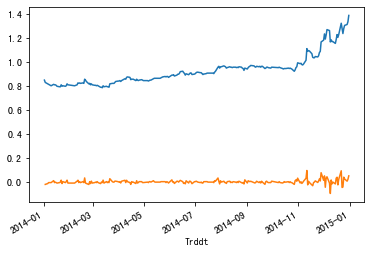

In [68]:
log_PAf.plot()
log_PAf.diff()[1:].plot()

In [69]:
log_PBf = np.log(PBf) #协整关系
adfB = ADF(log_PBf) 
print(adfB.summary().as_text()) #ADF自相关

   Augmented Dickey-Fuller Results   
Test Statistic                  2.392
P-value                         0.999
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [74]:
model = sm.OLS(log_PBf,sm.add_constant(log_PAf)).fit()
model.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>         <td>600000</td>      <th>  R-squared:         </th> <td>   0.949</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.949</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   4560.</td> 
</tr>
<tr>
  <th>Date:</th>             <td>Sat, 25 Apr 2020</td> <th>  Prob (F-statistic):</th> <td>1.83e-159</td>
</tr>
<tr>
  <th>Time:</th>                 <td>18:42:22</td>     <th>  Log-Likelihood:    </th> <td>  509.57</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>   245</td>      <th>  AIC:               </th> <td>  -1015.</td> 
</tr>
<tr>
  <th>Df Residuals:</th>          <td>   243</td>      <th>  BIC:               </th> <td>  -1008.</td> 
</tr>
<tr>
  <th>Df Model:</th>              <td>     1</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
     <td></td>       <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>const</th>  <td>    1.2269</td> <td>    0.015</td> <td>   83.071</td> <td> 0.000</td> <td>    1.198</td> <td>    1.256</td>
</tr>
<tr>
  <th>601988</th> <td>    1.0641</td> <td>    0.016</td> <td>   67.531</td> <td> 0.000</td> <td>    1.033</td> <td>    1.095</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>19.538</td> <th>  Durbin-Watson:     </th> <td>   0.161</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td> <th>  Jarque-Bera (JB):  </th> <td>  13.245</td>
</tr>
<tr>
  <th>Skew:</th>          <td> 0.444</td> <th>  Prob(JB):          </th> <td> 0.00133</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 2.286</td> <th>  Cond. No.          </th> <td>    15.2</td>
</tr>
</table><br/><br/>Warnings:<br/>[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [75]:
alpha = model.params[0]
beta = model.params[1]

In [76]:
spreadf = log_PBf - beta*log_PAf - alpha
spreadf

Trddt
2014-01-02   -0.011214
2014-01-03   -0.011507
2014-01-06    0.006511
2014-01-07    0.005361
2014-01-08    0.016112
                ...   
2014-12-25    0.027720
2014-12-26    0.035399
2014-12-29    0.039147
2014-12-30    0.041510
2014-12-31    0.007502
Length: 245, dtype: float64

In [77]:
adfSpread  = ADF(spreadf)
print(adfSpread.summary().as_text())

mu = np.mean(spreadf)
sd = np.std(spreadf)

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.193
P-value                         0.020
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [80]:
tradeStart = '2015-01-01'
tradeEnd = '2015-06-03'
PAt = PA[tradeStart:tradeEnd]
PBt = PB[tradeStart:tradeEnd]
CospreadT = np.log(PBt)-beta*np.log(PAt)-alpha
CospreadT.describe()

count    101.000000
mean      -0.039812
std        0.054575
min       -0.163903
25%       -0.063720
50%       -0.040649
75%        0.002773
max        0.057989
dtype: float64

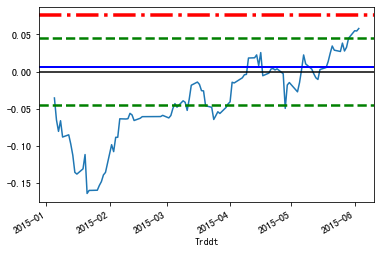

In [83]:
CospreadT.plot()
plt.axhline(y=mu,color = 'black')
plt.axhline(y=mu+0.2*sd,color = 'blue',ls='-',lw=2)
plt.axhline(y=mu+1.5*sd,color = 'green',ls='--',lw = 2.5)
plt.axhline(y=mu-1.5*sd,color = 'green',ls='--',lw = 2.5)
plt.axhline(y=mu+2.5*sd,color = 'red',ls='-.',lw=3.5)